In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
import seaborn as sns
from sklearn.utils import resample

# 1. Predicting Aggregate Measure with KBest

Our aggregate measure of vascular risk is a discrete categorical variable. Therefore,
we considered that the optimal algorithm to predict it is a supervised learning model
for the classification of the aggregate measure, which values range from 0 to 5. In
addition, due to the imbalanced nature of our target variable, we considered that
the best algorithm to choose is Random Forest (RF) from the "ensemble" class in
Scikit-learn [1].

In [2]:
# Loading the data
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1428)

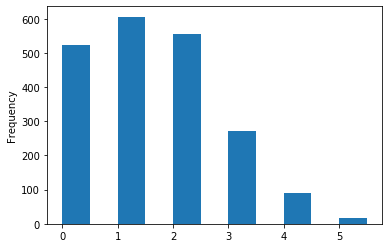

In [3]:
# Cardiovascular risk score
Y0 = data["agg_score"]
bin_values = np.arange(start=0, stop=6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [4]:
# Splitting each class from our target variable
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S345 = pd.concat((S3, S4, S5), axis=0)
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape, S345.shape

((523, 1428),
 (606, 1428),
 (555, 1428),
 (273, 1428),
 (91, 1428),
 (17, 1428),
 (381, 1428))

Random undersampling involves randomly selecting examples from the majority
class to delete from the training dataset. This has the effect of reducing the number
of examples in the majority class in the transformed version of the training dataset.
This process can be repeated until the desired class distribution is achieved, such as
an equal number of examples for each class. 

In [5]:
# Undersampling majority class
S1_under = resample(S1, replace=False, n_samples=523, random_state=123) 
S_0vs1 = pd.concat((S0, S1_under), axis=0)
S2_under = resample(S2, replace=False, n_samples=523, random_state=123)
S_0vs2 = pd.concat((S0, S2_under), axis=0)
S0_under1 = resample(S0, replace=False, n_samples=273, random_state=123)
S_0vs3 = pd.concat((S0_under1, S3), axis=0)
S0_under2 = resample(S0, replace=False, n_samples=91, random_state=123)
S_0vs4 = pd.concat((S0_under2, S4), axis=0)
S0_under3 = resample(S0, replace=False, n_samples=17, random_state=123)
S_0vs5 = pd.concat((S0_under3, S5), axis=0)
S0_under4 = resample(S0, replace=False, n_samples=381, random_state=123)
S_0vs345 = pd.concat((S0_under4, S345), axis=0)
S_0vs1.shape, S_0vs2.shape, S_0vs3.shape, S_0vs4.shape, S_0vs5.shape, S_0vs345.shape 

((1046, 1428), (1046, 1428), (546, 1428), (182, 1428), (34, 1428), (762, 1428))

In [6]:
# Mapping values in binarized targets
S_0vs1["agg_score"] = S_0vs1["agg_score"].map({0:0, 1:1})
S_0vs2["agg_score"] = S_0vs2["agg_score"].map({0:0, 2:1})
S_0vs3["agg_score"] = S_0vs3["agg_score"].map({0:0, 3:1})
S_0vs4["agg_score"] = S_0vs4["agg_score"].map({0:0, 4:1})
S_0vs5["agg_score"] = S_0vs5["agg_score"].map({0:0, 5:1})
S_0vs345["agg_score"] = S_0vs345["agg_score"].map({0:0, 3:1, 4:1, 5:1})

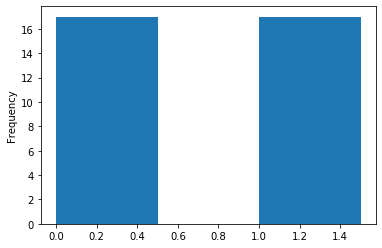

In [7]:
# Visualizing binary target class
Y0 = S_0vs5["agg_score"]
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [8]:
# Filtering data groups
heart_df = S_0vs5.filter(regex='heart')
cardio_cmr_df = S_0vs5.filter(regex='cardio_cmr')
brain_df = S_0vs5.filter(regex='brain')
heart_df.shape, brain_df.shape, cardio_cmr_df.shape

((34, 630), (34, 744), (34, 9))

In [9]:
# our model
RF = RandomForestClassifier()

This popular technique consists of a combination of decision trees (DTs) trained on
different random samples of the training set. Each DT is a set of rules based on the
input features values optimized for accurately classifying all elements of the training
set. DTs are nonlinear models and tend to have high variance

## 1.1 Predicting aggregate measure of vascular risk with heart variables

In [10]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df

In [11]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 630), (11, 630), (23,), (11,))

In [12]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [14]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.7272727272727273

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.80      0.67      0.73         6

    accuracy                           0.73        11
   macro avg       0.73      0.73      0.73        11
weighted avg       0.74      0.73      0.73        11



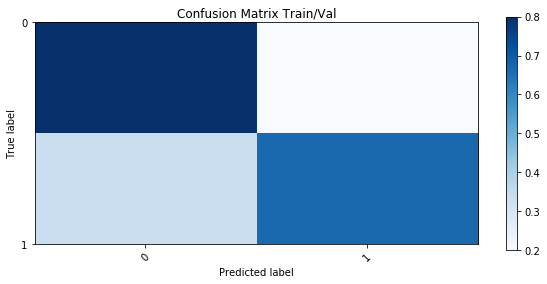

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
cols = selector.get_support(indices=True)
features = heart_df.iloc[:,cols]
K_best_heart = list(features) 
K_best_heart

['heart_Sphericity_LV_ED_shape',
 'heart_Sphericity_LV_ES_shape',
 'heart_Minimum_RV_ES_intensity',
 'heart_InformalMeasureofCorrelation2_glcm_LV_ED_texture',
 'heart_GrayLevelNonUniformity_glrlm_MYO_ES_texture']

In [18]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [20]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.7333


In [21]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

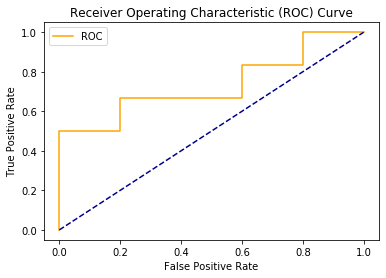

In [22]:
plot_roc_curve(fpr, tpr)

## 1.2 Predicting aggregate measure of vascular risk with CMR variables

In [23]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df

In [24]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 9), (11, 9), (23,), (11,))

In [25]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [27]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.6363636363636364

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.75      0.50      0.60         6

    accuracy                           0.64        11
   macro avg       0.66      0.65      0.63        11
weighted avg       0.67      0.64      0.63        11



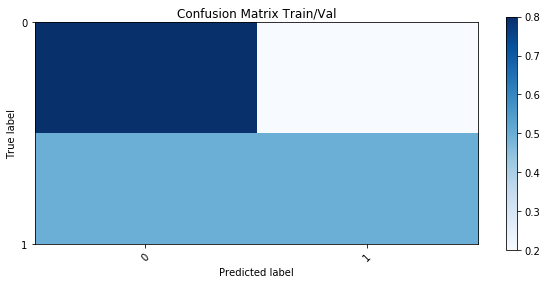

In [29]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
cols = selector.get_support(indices=True)
features = cardio_cmr_df.iloc[:,cols]
K_best_cmr = list(features) 
K_best_cmr

['cardio_cmr_LVEDV_i',
 'cardio_cmr_LVSV_i',
 'cardio_cmr_LVEF',
 'cardio_cmr_RVEDV_i',
 'cardio_cmr_RVSV_i']

In [31]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [32]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [33]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.7333


In [34]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

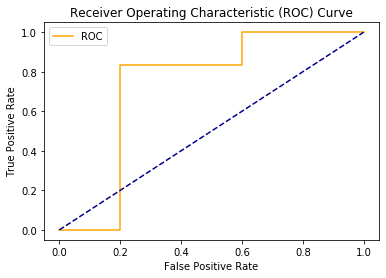

In [35]:
plot_roc_curve(fpr, tpr)

## 1.3 Predicting aggregate measure of vascular risk with brain variables

In [36]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = brain_df

In [37]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 744), (11, 744), (23,), (11,))

In [38]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [40]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.8181818181818182

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



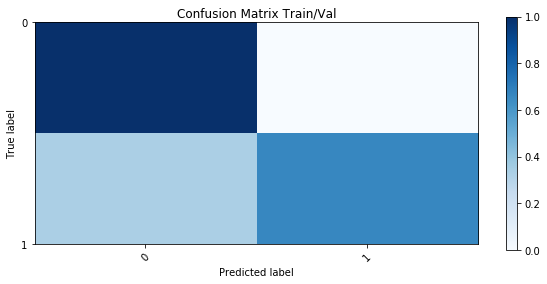

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
cols = selector.get_support(indices=True)
features = brain_df.iloc[:,cols]
K_best_brain = list(features) 
K_best_brain

['brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging',
 'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
 'brain_bio_median_t2star_in_amygdala__right__0_imaging',
 'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging']

In [44]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [45]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.8667


In [46]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

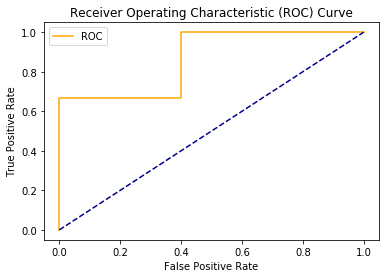

In [47]:
plot_roc_curve(fpr, tpr)

## 1.4 Predicting aggregate measure of vascular risk with heart/brain combinations

In [48]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df
X2 = brain_df
X1.shape, X2.shape

((34, 630), (34, 744))

In [49]:
# Combining datasets
X_combination_cfa = pd.concat((X1, X2), axis=1)
X_combination_cfa.shape

(34, 1374)

In [50]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_combination_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 1374), (11, 1374), (23,), (11,))

In [51]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [53]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.6363636363636364

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.67      0.67         6

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11



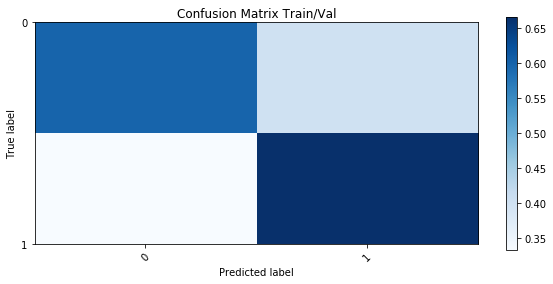

In [55]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
cols = selector.get_support(indices=True)
features = X_combination_cfa.iloc[:,cols]
K_best_heart_brain = list(features) 
K_best_heart_brain

['heart_Sphericity_LV_ES_shape',
 'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
 'brain_bio_median_t2star_in_amygdala__right__0_imaging',
 'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging']

In [57]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [58]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.8667


In [59]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

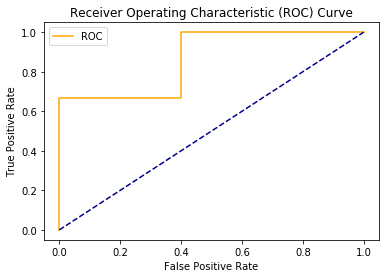

In [60]:
plot_roc_curve(fpr, tpr)

## 1.5 Predicting aggregate measure of vascular risk with CMR/brain combinations

In [61]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df
X2 = brain_df
X1.shape, X2.shape

((34, 9), (34, 744))

In [62]:
# Combining datasets
X_combination_cfa2 = pd.concat((X1, X2), axis=1)
X_combination_cfa2.shape

(34, 753)

In [63]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_combination_cfa2, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 753), (11, 753), (23,), (11,))

In [64]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [66]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.6363636363636364

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.67      0.67         6

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11



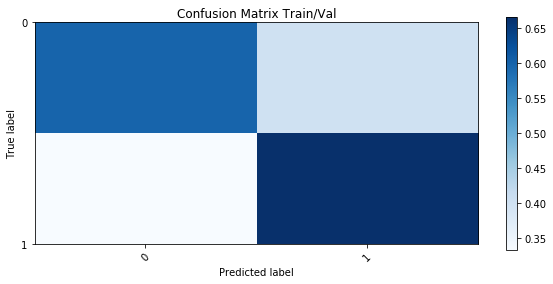

In [68]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
cols = selector.get_support(indices=True)
features = X_combination_cfa2.iloc[:,cols]
K_best_cmr_brain = list(features) 
K_best_cmr_brain

['brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging',
 'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
 'brain_bio_median_t2star_in_amygdala__right__0_imaging',
 'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging']

In [70]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [71]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.8333


In [72]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

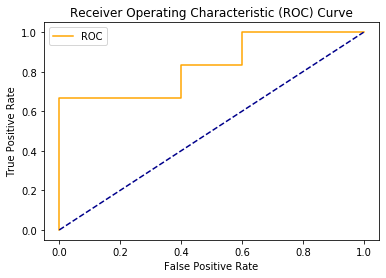

In [73]:
plot_roc_curve(fpr, tpr)

## 1.6 Correlation Plots

In [74]:
K_best_heart, K_best_cmr, K_best_brain, K_best_heart_brain, K_best_cmr_brain

(['heart_Sphericity_LV_ED_shape',
  'heart_Sphericity_LV_ES_shape',
  'heart_Minimum_RV_ES_intensity',
  'heart_InformalMeasureofCorrelation2_glcm_LV_ED_texture',
  'heart_GrayLevelNonUniformity_glrlm_MYO_ES_texture'],
 ['cardio_cmr_LVEDV_i',
  'cardio_cmr_LVSV_i',
  'cardio_cmr_LVEF',
  'cardio_cmr_RVEDV_i',
  'cardio_cmr_RVSV_i'],
 ['brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging',
  'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
  'brain_bio_median_t2star_in_amygdala__right__0_imaging',
  'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
  'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging'],
 ['heart_Sphericity_LV_ES_shape',
  'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
  'brain_bio_median_t2star_in_amygdala__right__0_imaging',
  'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
  'brain_

In [80]:
# Create dataframes
corr_heart_brain = data.filter(['heart_Sphericity_LV_ED_shape', 
                         'heart_Sphericity_LV_ES_shape',
                         'heart_Minimum_RV_ES_intensity',
                         'heart_InformalMeasureofCorrelation2_glcm_LV_ED_texture',
                         'heart_GrayLevelNonUniformity_glrlm_MYO_ES_texture',
                         'brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging',
                         'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
                         'brain_bio_median_t2star_in_amygdala__right__0_imaging',
                         'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
                         'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging'], axis=1)

corr_cmr_brain = data.filter(['cardio_cmr_LVEDV_i', 
                         'cardio_cmr_LVESV_i',
                         'cardio_cmr_LVEF',
                         'cardio_cmr_RVEDV_i',
                         'cardio_cmr_RVSV_i',
                         'brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging',
                         'brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging',
                         'brain_bio_median_t2star_in_amygdala__right__0_imaging',
                         'brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging',
                         'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging'], axis=1)

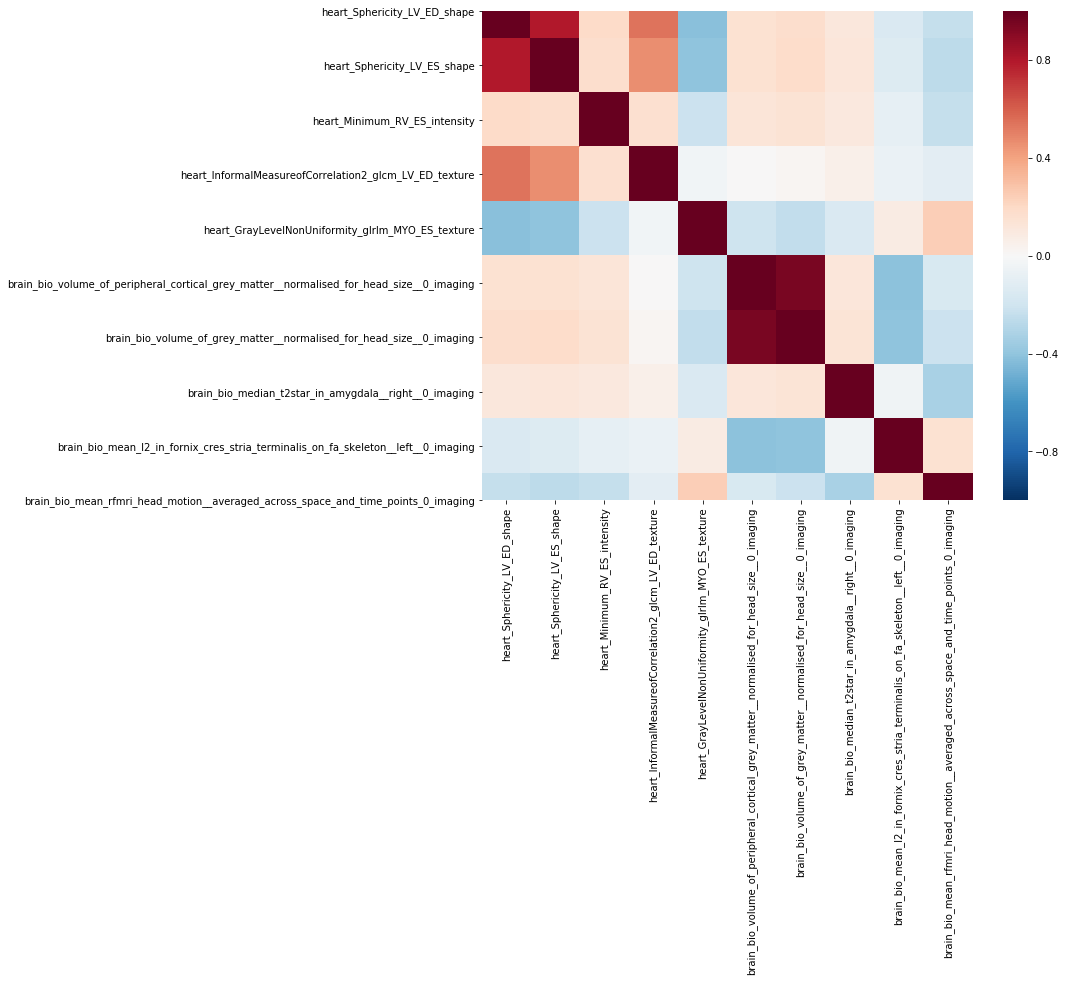

In [81]:
heart_brain_corr = corr_heart_brain.corr()
plt.figure(figsize=(11,9))
sns.heatmap(heart_brain_corr, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
plt.show()

In [82]:
heart_brain_corr

,heart_Sphericity_LV_ED_shape,heart_Sphericity_LV_ES_shape,heart_Minimum_RV_ES_intensity,heart_InformalMeasureofCorrelation2_glcm_LV_ED_texture,heart_GrayLevelNonUniformity_glrlm_MYO_ES_texture,brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging,brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging,brain_bio_median_t2star_in_amygdala__right__0_imaging,brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging,brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging
heart_Sphericity_LV_ED_shape,1.000000,0.800405,0.190264,0.539882,-0.418375,0.148992,0.175091,0.116124,-0.152249,-0.240923
heart_Sphericity_LV_ES_shape,0.800405,1.000000,0.174024,0.463140,-0.400449,0.155706,0.184946,0.121133,-0.139151,-0.264148
heart_Minimum_RV_ES_intensity,0.190264,0.174024,1.000000,0.157702,-0.216347,0.129145,0.144175,0.106808,-0.087781,-0.241629
heart_InformalMeasureofCorrelation2_glcm_LV_ED_texture,0.539882,0.463140,0.157702,1.000000,-0.038227,0.007503,0.017726,0.060931,-0.067808,-0.107064
heart_GrayLevelNonUniformity_glrlm_MYO_ES_texture,-0.418375,-0.400449,-0.216347,-0.038227,1.000000,-0.210423,-0.246324,-0.150616,0.082190,0.243170
brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging,0.148992,0.155706,0.129145,0.007503,-0.210423,1.000000,0.950033,0.119352,-0.411674,-0.161927
brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging,0.175091,0.184946,0.144175,0.017726,-0.246324,0.950033,1.000000,0.134032,-0.406093,-0.214465
brain_bio_median_t2star_in_amygdala__right__0_imaging,0.116124,0.121133,0.106808,0.060931,-0.150616,0.119352,0.134032,1.000000,-0.044940,-0.320882
brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging,-0.152249,-0.139151,-0.087781,-0.067808,0.082190,-0.411674,-0.406093,-0.044940,1.000000,0.154118
brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.240923,-0.264148,-0.241629,-0.107064,0.243170,-0.161927,-0.214465,-0.320882,0.154118,1.000000


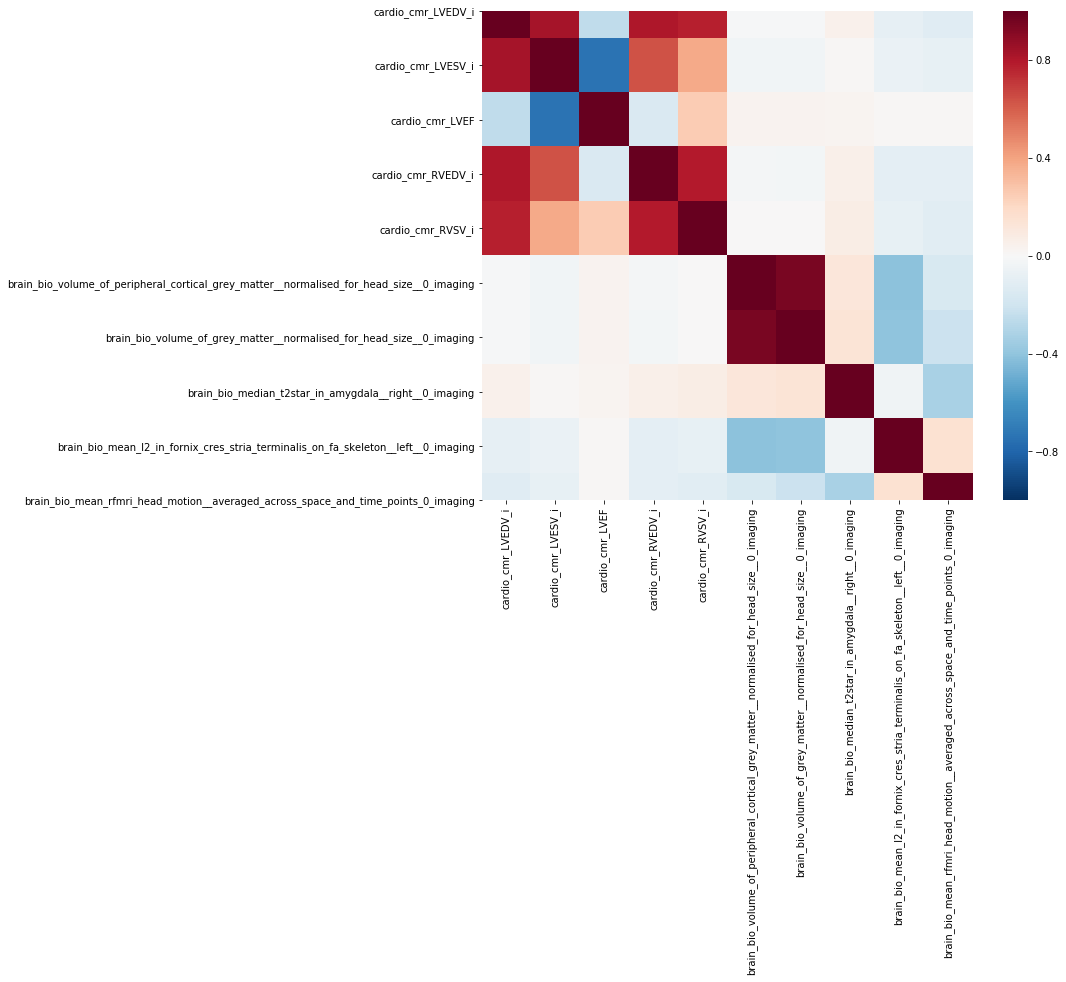

In [83]:
cmr_brain_corr = corr_cmr_brain.corr()
plt.figure(figsize=(11,9))
sns.heatmap(cmr_brain_corr, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
plt.show()

In [84]:
cmr_brain_corr

,cardio_cmr_LVEDV_i,cardio_cmr_LVESV_i,cardio_cmr_LVEF,cardio_cmr_RVEDV_i,cardio_cmr_RVSV_i,brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging,brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging,brain_bio_median_t2star_in_amygdala__right__0_imaging,brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging,brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging
cardio_cmr_LVEDV_i,1.000000,0.832724,-0.257471,0.806088,0.774736,-0.013272,-0.012954,0.047714,-0.088035,-0.119604
cardio_cmr_LVESV_i,0.832724,1.000000,-0.739175,0.636581,0.377506,-0.031297,-0.031579,0.011248,-0.063240,-0.083726
cardio_cmr_LVEF,-0.257471,-0.739175,1.000000,-0.153762,0.255656,0.035896,0.039049,0.030187,0.008146,0.010295
cardio_cmr_RVEDV_i,0.806088,0.636581,-0.153762,1.000000,0.796017,-0.016818,-0.024425,0.059393,-0.095826,-0.095598
cardio_cmr_RVSV_i,0.774736,0.377506,0.255656,0.796017,1.000000,0.007807,0.005348,0.070559,-0.084985,-0.116529
brain_bio_volume_of_peripheral_cortical_grey_matter__normalised_for_head_size__0_imaging,-0.013272,-0.031297,0.035896,-0.016818,0.007807,1.000000,0.950033,0.119352,-0.411674,-0.161927
brain_bio_volume_of_grey_matter__normalised_for_head_size__0_imaging,-0.012954,-0.031579,0.039049,-0.024425,0.005348,0.950033,1.000000,0.134032,-0.406093,-0.214465
brain_bio_median_t2star_in_amygdala__right__0_imaging,0.047714,0.011248,0.030187,0.059393,0.070559,0.119352,0.134032,1.000000,-0.044940,-0.320882
brain_bio_mean_l2_in_fornix_cres_stria_terminalis_on_fa_skeleton__left__0_imaging,-0.088035,-0.063240,0.008146,-0.095826,-0.084985,-0.411674,-0.406093,-0.044940,1.000000,0.154118
brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.119604,-0.083726,0.010295,-0.095598,-0.116529,-0.161927,-0.214465,-0.320882,0.154118,1.000000


# 2. References

[1] [Pedregosa, F. et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf). Scikit-learn: Machine Learning in Python.